# Решение задачи OneMax с помощью генетических алгоритмов

Задача OneMax состоит в том, чтобы найти двоичную строку заданной длины, для которой сумма составляющих ее цифр максимальна. Очевидно (нам), что решением всегда является строка, состоящая из одних единиц. Но генетический алгоритм не обладает таким знанием, поэтому
должен слепо искать решение, пользуясь генетическими операторами.

In [1]:
import random
from typing import Tuple

from deap import base
from deap import creator
from deap import tools

import matplotlib.pyplot as plt
%matplotlib inline

## Ручная организация эволюционного цикла

### Подготовка

Константы, содержащие значения параметров самой задачи и генетического алгоритма:

In [2]:
# константы задачи
ONE_MAX_LENGTH = 100 # длина подлежащей оптимизации битовой строки

# константы генетического алгоритма
POPULATION_SIZE = 200 # количество индивидуумов в популяции
P_CROSSOVER = 0.9 # вероятность скрещивания
P_MUTATION = 0.1 # вероятность мутации индивидуума
MAX_GENERATIONS = 50 # максимальное количество поколений

Зафиксировать начальное значение генератора случайных чисел.

In [3]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

Создать Toolbox и зарегистрировать оператор для генерации битов хромосомы.

In [4]:
toolbox = base.Toolbox()
toolbox.register('zero_or_one', random.randint, 0, 1)

Создать класс Fitness.

In [5]:
creator.create('FitnessMax', base.Fitness, weights=(1.0, ))

Создать класс Individual для представления хромосомы.

In [6]:
creator.create('Individual', list, fitness=creator.FitnessMax)

Зарегистрировать оператор для создания индивидуума.

In [7]:
toolbox.register(
    'individual_creator',
    tools.initRepeat,
    creator.Individual,
    toolbox.zero_or_one,
    ONE_MAX_LENGTH
)

Зарегистрировать оператор для создания списка индивидуумов.

In [8]:
toolbox.register(
    'population_creator',
    tools.initRepeat,
    list,
    toolbox.individual_creator
)

Определить функцию для вычисления приспособленности.

In [9]:
def onemax_fitness(individual: creator.Individual) -> Tuple[int]:
    return sum(individual),

In [10]:
toolbox.register('evaluate', onemax_fitness)

Зарегистрировать генетические операторы.

In [11]:
toolbox.register(
    'select', 
    tools.selTournament,
    tournsize=3
)
toolbox.register('mate', tools.cxOnePoint)
toolbox.register(
    'mutate',
    tools.mutFlipBit,
    indpb=1.0/ONE_MAX_LENGTH
)

### Эволюция решения

Создать популяцию.

In [12]:
population = toolbox.population_creator(n=POPULATION_SIZE)
counter = 0

Определить значение приспособленности для каждого индивидуума.

In [13]:
fitness_values = list(map(toolbox.evaluate, population))

for individual, fitness_value in zip(population, fitness_values):
    individual.fitness.values = fitness_value

fitness_values = [individual.fitness.values[0] for individual in population]

Необходимо собрать для статистики среднее и максимальное значение приспособленности в каждом поколении.

In [14]:
history = {
    'max': [max(fitness_values)],
    'avg': [sum(fitness_values) / len(fitness_values)], 
}

Главный эволюционный цикл алгоритма.

In [15]:
while max(fitness_values) < ONE_MAX_LENGTH and counter < MAX_GENERATIONS:
    counter += 1

    # Выполнить отбор.
    offspring = toolbox.select(population, len(population))
    # Клонировать индивидуумы.
    offspring = [toolbox.clone(individual) for individual in offspring]

    # Выполнить скрещивание.
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < P_CROSSOVER:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values 

    # Применить оператор мутации.
    for mutant in offspring:
        if random.random() < P_MUTATION:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Определить приспособленность для новых индивидуумов.
    fresh_individuals = [
        individual for individual in offspring if not individual.fitness.valid
    ]
    fresh_fitness_values = list(map(toolbox.evaluate, fresh_individuals))
    for individual, fitness_value in zip(fresh_individuals, fresh_fitness_values):
        individual.fitness.values = fitness_value

    # Обновить популяцию.
    population = offspring.copy()
    fitness_values = [individual.fitness.values[0] for individual in population]

    # Получить данные статистики.
    max_fitness = max(fitness_values)
    avg_fitness = sum(fitness_values) / len(fitness_values)

    history['max'].append(max_fitness)
    history['avg'].append(avg_fitness)

    print(
        f"Поколение {counter}: max fitness = {max_fitness}, "
        f"average fitness = {avg_fitness}"
    )

    # Получить индивидуум с максимальной приспособленностью.
    idx = fitness_values.index(max_fitness)
    print(f"Лучший индивидуум: {population[idx]}\n")

Поколение 1: max fitness = 65.0, average fitness = 53.575
Лучший индивидуум: [1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]

Поколение 2: max fitness = 66.0, average fitness = 56.855
Лучший индивидуум: [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]

Поколение 3: max fitness = 69.0, average fitness = 59.42
Лучший индивидуум: [1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 

Отобразить процесс изменения значений средней и максимальной приспособленности в процессе работы алгоритма.

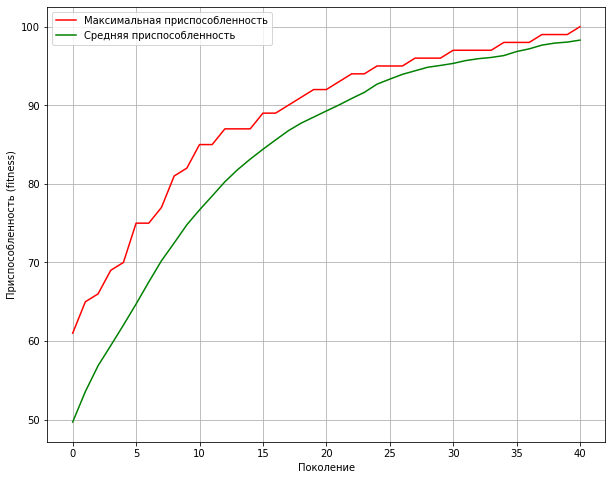

In [16]:
_, ax = plt.subplots(figsize=(10, 8))

ax.plot(
    history['max'],
    color='red',
    label="Максимальная приспособленность"
)
ax.plot(
    history['avg'],
    color='green',
    label="Средняя приспособленность"
)

ax.set_xlabel("Поколение")
ax.set_ylabel("Приспособленность (fitness)")
ax.grid(True)
ax.legend()

plt.show();

## Использование встроенных алгоритмов

In [17]:
import numpy as np

from deap import algorithms

Создать популяцию.

In [18]:
population = toolbox.population_creator(n=POPULATION_SIZE)

Создать объект статистики.

In [19]:
stats = tools.Statistics(lambda ind: ind.fitness.values)

Зарегистрировать функции, применяемые на каждом шаге.

In [20]:
stats.register('max', np.max)
stats.register('avg', np.mean)
stats.register('min', np.min)

Запустить эволюционный алгоритм.

In [21]:
population, logbook = algorithms.eaSimple(
    population,
    toolbox,
    cxpb=P_CROSSOVER,
    mutpb=P_MUTATION,
    ngen=MAX_GENERATIONS,
    stats=stats,
    verbose=True
)

gen	nevals	max	avg  	min
0  	200   	64 	49.33	34 
1  	179   	63 	54.075	43 
2  	187   	67 	57.095	49 
3  	182   	71 	60.595	51 
4  	182   	73 	63.78 	53 
5  	177   	74 	66.535	56 
6  	193   	75 	68.98 	63 
7  	186   	78 	71.37 	64 
8  	182   	81 	73.4  	68 
9  	185   	82 	75.42 	69 
10 	179   	82 	77.565	72 
11 	178   	83 	79.005	73 
12 	176   	85 	80.505	76 
13 	181   	89 	81.935	77 
14 	181   	89 	83.48 	78 
15 	184   	91 	84.96 	81 
16 	184   	92 	86.42 	82 
17 	184   	92 	87.96 	83 
18 	183   	93 	89.215	85 
19 	175   	95 	90.47 	85 
20 	179   	95 	91.54 	88 
21 	182   	96 	92.525	89 
22 	192   	97 	93.415	88 
23 	176   	97 	94.475	89 
24 	188   	98 	95.34 	93 
25 	180   	98 	96.165	93 
26 	184   	98 	96.78 	93 
27 	182   	98 	97.32 	94 
28 	188   	99 	97.6  	94 
29 	188   	99 	97.905	95 
30 	190   	99 	97.94 	95 
31 	190   	99 	98    	96 
32 	184   	99 	98.115	95 
33 	184   	99 	98.44 	96 
34 	189   	99 	98.78 	95 
35 	180   	99 	98.915	97 
36 	185   	99 	98.925	96 
37 	189   	99 

Отобразить процесс изменения значений средней и максимальной приспособленности в процессе работы алгоритма.

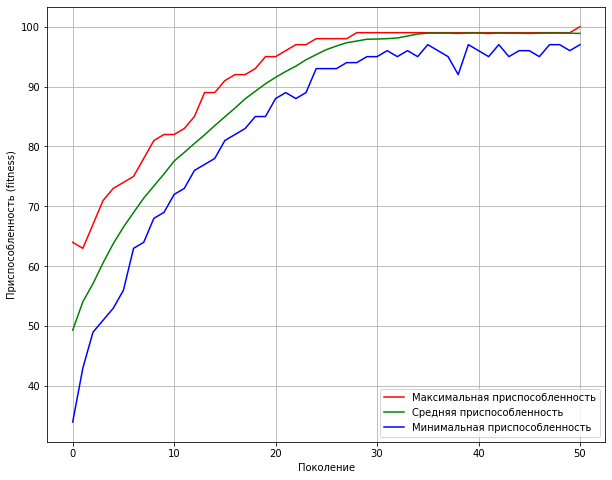

In [22]:
_, ax = plt.subplots(figsize=(10, 8))

ax.plot(
    logbook.select('max'),
    color='red',
    label="Максимальная приспособленность"
)
ax.plot(
    logbook.select('avg'),
    color='green',
    label="Средняя приспособленность"
)
ax.plot(
    logbook.select('min'),
    color='blue',
    label="Минимальная приспособленность"
)

ax.set_xlabel("Поколение")
ax.set_ylabel("Приспособленность (fitness)")
ax.grid(True)
ax.legend()

plt.show();

### Зал славы

Создать популяцию.

In [23]:
population = toolbox.population_creator(n=POPULATION_SIZE)

Определить константу, равную количеству индивидуумов, которых мы
хотим хранить в зале славы:

In [24]:
HALL_OF_FAME_SIZE = 10

Создать объект "зала славы".

In [25]:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

Запустить эволюционный цикл.

In [26]:
population, logbook = algorithms.eaSimple(
    population,
    toolbox,
    cxpb=P_CROSSOVER,
    mutpb=P_MUTATION,
    ngen=MAX_GENERATIONS,
    stats=stats,
    halloffame=hof,
    verbose=True
)

gen	nevals	max	avg   	min
0  	200   	64 	50.035	37 
1  	188   	66 	54.375	42 
2  	182   	68 	57.99 	49 
3  	189   	69 	61.285	52 
4  	184   	73 	64.165	57 
5  	185   	76 	66.685	57 
6  	177   	78 	69.33 	60 
7  	182   	79 	71.77 	65 
8  	180   	80 	74.05 	68 
9  	185   	82 	75.82 	64 
10 	174   	84 	77.875	72 
11 	181   	85 	79.72 	75 
12 	178   	86 	81.07 	76 
13 	180   	89 	82.76 	78 
14 	165   	89 	84.405	79 
15 	186   	92 	85.815	82 
16 	191   	92 	87.155	82 
17 	186   	93 	88.55 	84 
18 	192   	93 	89.815	87 
19 	184   	94 	90.88 	87 
20 	187   	95 	91.77 	88 
21 	189   	95 	92.73 	90 
22 	174   	95 	93.275	90 
23 	176   	96 	93.94 	92 
24 	166   	96 	94.45 	91 
25 	189   	96 	94.96 	90 
26 	184   	97 	95.36 	92 
27 	183   	97 	95.845	93 
28 	186   	98 	95.955	91 
29 	191   	99 	96.295	94 
30 	182   	99 	96.67 	93 
31 	181   	99 	97.1  	95 
32 	183   	99 	97.45 	94 
33 	180   	99 	98.03 	95 
34 	187   	99 	98.665	95 
35 	174   	99 	98.895	95 
36 	191   	99 	98.89 	95 
37 	188   	9

Отобразить все индивидуумы в зале славы:

In [27]:
for number, individual in enumerate(hof.items, 1):
    print(f"{number}: {individual} -> {sum(individual)}")

1: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] -> 100
2: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] -> 99
3: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] -> 99
4: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Отобразить наилучшего индивидуума в зале славы.

In [28]:
print(f"Лучший индивидуум: {hof.items[0]}")

Лучший индивидуум: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
